In [1]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools

Using TensorFlow backend.


In [2]:
#Loading data
path_train = "C:/Users/rosha/OneDrive/Documents/News/20news-bydate/20news-bydate-train"

In [3]:
#Preprocessing Data
files_train = skds.load_files(path_train,load_content=False) 
label_index = files_train.target
label_names = files_train.target_names
labelled_files = files_train.filenames
label_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
data_tags = ["filename","category","news"]
data_list = []

In [5]:
# Read and add data from file to a list
i=0
for f in labelled_files:
    data_list.append((f,label_names[label_index[i]],Path(f).read_text()))
    i += 1
 
# We have training data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)

In [7]:
# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data) * .8)
 
train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]
 
test_posts = data['news'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]

In [8]:
# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)
 
x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

 


In [71]:
x_test.shape

(2263, 15000)

In [13]:
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [74]:
y_test.shape

(2263, 20)

In [46]:
#Creating Model
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               7680512   
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                10260     
__________

In [47]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])
 
text_labels = encoder.classes_
 
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

2263/2263 [==============================] - 1s 531us/step
Test accuracy: 0.8714096285155849
C:/Users/rosha/OneDrive/Documents/News/20news-bydate/20news-bydate-train\alt.atheism\53114
Actual label:alt.atheism
Predicted label: alt.atheism
C:/Users/rosha/OneDrive/Documents/News/20news-bydate/20news-bydate-train\comp.graphics\38666
Actual label:comp.graphics
Predicted label: comp.graphics
C:/Users/rosha/OneDrive/Documents/News/20news-bydate/20news-bydate-train\sci.med\58932
Actual label:sci.med
Predicted label: sci.med
C:/Users/rosha/OneDrive/Documents/News/20news-bydate/20news-bydate-train\sci.crypt\15212
Actual label:sci.crypt
Predicted label: sci.crypt
C:/Users/rosha/OneDrive/Documents/News/20news-bydate/20news-bydate-train\comp.os.ms-windows.misc\9695
Actual label:comp.os.ms-windows.misc
Predicted label: comp.os.ms-windows.misc
C:/Users/rosha/OneDrive/Documents/News/20news-bydate/20news-bydate-train\rec.sport.baseball\104482
Actual label:rec.sport.baseball
Predicted label: rec.sport.b

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




Normalized confusion matrix


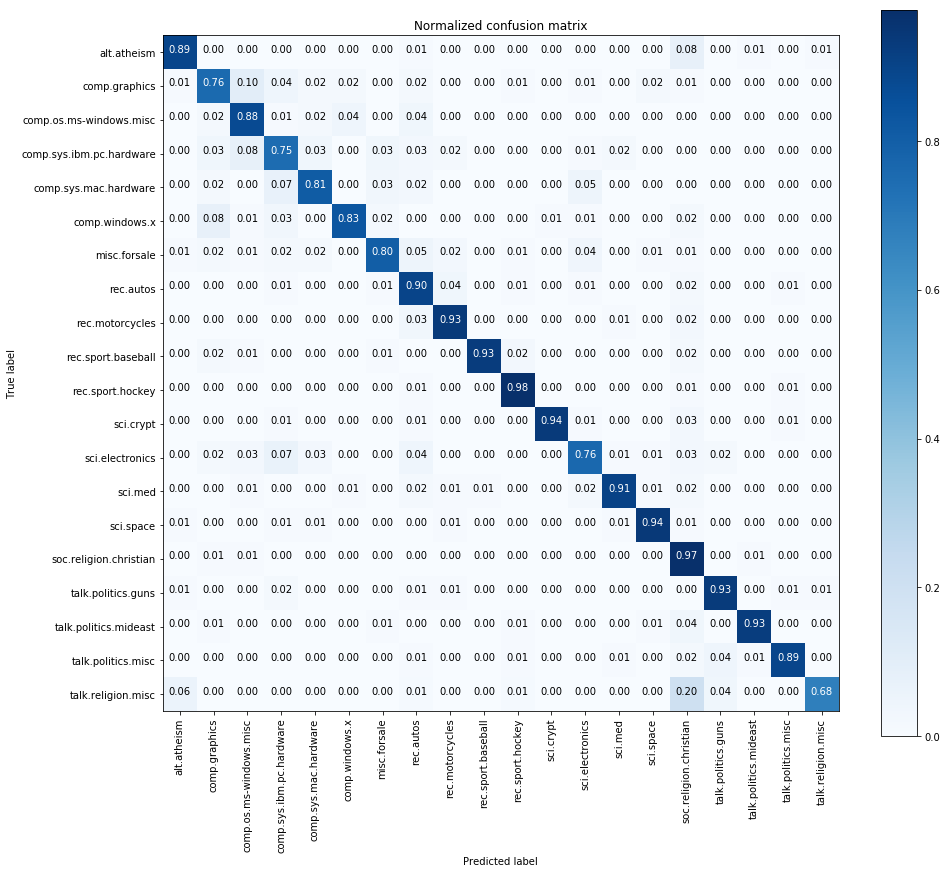

In [59]:
y_pred = model.predict(x_test)
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
fig.align_labels()

fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')



In [75]:
#CNN model

In [9]:
from keras import layers
maxlen=15000

In [14]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15000, 100)        1500000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14996, 128)        64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1300      
Total params: 1,573,684
Trainable params: 1,573,684
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=100)

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
max_words=15000
model = Sequential()
model.add(Embedding(max_words, output_dim=128, mask_zero=True))
model.add(LSTM(60))
model.add(Dropout(0.3))
model.add(Dense(20, activation='softmax'))

In [29]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
output = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.2)

Train on 7240 samples, validate on 1811 samples
Epoch 1/1
7240/7240 [==============================] - 27657s 4s/step - loss: 0.1967 - acc: 0.9500 - val_loss: 0.1943 - val_acc: 0.9500


In [31]:
vis.metrics(output.history)

NameError: name 'vis' is not defined

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print('Test accuracy:', score[1])